# Step 1: Get Data

## Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
train_data = pd.read_csv ('train.csv')
test_data = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

train_data.shape, test_data.shape, submission.shape

((10500, 5), (4500, 4), (4500, 2))

# Step 2: Data Preprocessing

## Training Data

In [3]:
train_data.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male


In [4]:
train_data['ProductList'][0]

'A00002/B00003/C00006/D28435/;A00002/B00003/C00006/D02554/;A00002/B00003/C00006/D28436/;A00002/B00003/C00006/D28437/'

In [5]:
train_data['ProductListCount'] = train_data['ProductList'].apply(lambda x: len(x.split(";")))

# Create product list - Separating each product to new row (;)
prod = train_data['ProductList'].str.split(';')
train_data = train_data.reindex(train_data.index.repeat(prod.apply(len)))
train_data['product_data'] = np.hstack(prod)

#product_data list are separated by forward slash (/). They need to be split into product, category, category, sub_sub_category
#added other category to see if there is more
train_data[['category','sub_category','sub_sub_category','product','other']] = train_data.product_data.str.split('[/]', expand=True)

#Drop original productlist, product_data and other columns as they are not needed
train_data.drop(['ProductList', 'ProductListCount', 'product_data','other'], axis=1, inplace=True)

#Display data
train_data.head()

,session_id,startTime,endTime,gender,category,sub_category,sub_sub_category,product
0,u16159,15/12/14 18:11,15/12/14 18:12,female,A00002,B00003,C00006,D28435
0,u16159,15/12/14 18:11,15/12/14 18:12,female,A00002,B00003,C00006,D02554
0,u16159,15/12/14 18:11,15/12/14 18:12,female,A00002,B00003,C00006,D28436
0,u16159,15/12/14 18:11,15/12/14 18:12,female,A00002,B00003,C00006,D28437
1,u10253,16/12/14 14:35,16/12/14 14:41,male,A00001,B00009,C00031,D29404


In [6]:
train_data['category'].value_counts()

A00002    14931
A00003     3822
A00001     3300
A00005      413
A00004      261
A00006      182
A00011      130
A00010       75
A00007       52
A00009       47
A00008       38
Name: category, dtype: int64

In [7]:
#find the unique values across the column axis.
train_data.nunique()

session_id          10500
startTime            8815
endTime              8803
gender                  2
category               11
sub_category           85
sub_sub_category      360
product             16503
dtype: int64

### Features Engineering

#### Datetime Features

In [8]:
#Convert startTime and endTime to datetime format
train_data["startTime"]= pd.to_datetime(train_data["startTime"])
train_data["endTime"]= pd.to_datetime(train_data["endTime"])

#merged_train["closeddate"]= [datetime.timestamp(i) for i in merged_train.closeddate]



date_column= ['startTime', 'endTime']

def extract_date(train_data,cols):
    for x in cols:
        train_data[x +'_year'] = train_data[x].dt.year
        train_data[x +'_month'] = train_data[x].dt.month
        train_data[x +'_week'] = train_data[x].dt.week
        train_data[x +'_day'] = train_data[x].dt.day
        train_data[x +'_hour'] = train_data[x].dt.hour
        train_data[x +'_minute'] = train_data[x].dt.minute
        train_data[x +'_dayofweek'] = train_data[x].dt.dayofweek
          
extract_date(train_data, date_column)

train_data.columns

Index(['session_id', 'startTime', 'endTime', 'gender', 'category',
       'sub_category', 'sub_sub_category', 'product', 'startTime_year',
       'startTime_month', 'startTime_week', 'startTime_day', 'startTime_hour',
       'startTime_minute', 'startTime_dayofweek', 'endTime_year',
       'endTime_month', 'endTime_week', 'endTime_day', 'endTime_hour',
       'endTime_minute', 'endTime_dayofweek'],
      dtype='object')

In [9]:
train_data['duration'] = (train_data['endTime']-train_data['startTime']).dt.total_seconds()

#Dropping previous date columns after etracting year, day, month and quarters
train_data.drop(columns=date_column,axis=1,inplace=True)

In [10]:
train_data.head()

,session_id,gender,category,sub_category,sub_sub_category,product,startTime_year,startTime_month,startTime_week,startTime_day,...,startTime_minute,startTime_dayofweek,endTime_year,endTime_month,endTime_week,endTime_day,endTime_hour,endTime_minute,endTime_dayofweek,duration
0,u16159,female,A00002,B00003,C00006,D28435,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,60.0
0,u16159,female,A00002,B00003,C00006,D02554,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,60.0
0,u16159,female,A00002,B00003,C00006,D28436,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,60.0
0,u16159,female,A00002,B00003,C00006,D28437,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,60.0
1,u10253,male,A00001,B00009,C00031,D29404,2014,12,51,16,...,35,1,2014,12,51,16,14,41,1,360.0


#### Missing Values

In [11]:
#check duplicates
train_data.duplicated().sum()

0

In [12]:
#Check missing values
train_data.isnull().any()

session_id             False
gender                 False
category               False
sub_category           False
sub_sub_category       False
product                False
startTime_year         False
startTime_month        False
startTime_week         False
startTime_day          False
startTime_hour         False
startTime_minute       False
startTime_dayofweek    False
endTime_year           False
endTime_month          False
endTime_week           False
endTime_day            False
endTime_hour           False
endTime_minute         False
endTime_dayofweek      False
duration               False
dtype: bool

#### Encoding Categorical Variables

In [13]:
train_data.dtypes

session_id              object
gender                  object
category                object
sub_category            object
sub_sub_category        object
product                 object
startTime_year           int64
startTime_month          int64
startTime_week           int64
startTime_day            int64
startTime_hour           int64
startTime_minute         int64
startTime_dayofweek      int64
endTime_year             int64
endTime_month            int64
endTime_week             int64
endTime_day              int64
endTime_hour             int64
endTime_minute           int64
endTime_dayofweek        int64
duration               float64
dtype: object

In [14]:
# using .map to create dummy variables
train_data['gender'] = train_data.gender.map({'female':0, 'male':1})

In [15]:
train_data.head()

,session_id,gender,category,sub_category,sub_sub_category,product,startTime_year,startTime_month,startTime_week,startTime_day,...,startTime_minute,startTime_dayofweek,endTime_year,endTime_month,endTime_week,endTime_day,endTime_hour,endTime_minute,endTime_dayofweek,duration
0,u16159,0,A00002,B00003,C00006,D28435,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,60.0
0,u16159,0,A00002,B00003,C00006,D02554,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,60.0
0,u16159,0,A00002,B00003,C00006,D28436,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,60.0
0,u16159,0,A00002,B00003,C00006,D28437,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,60.0
1,u10253,1,A00001,B00009,C00031,D29404,2014,12,51,16,...,35,1,2014,12,51,16,14,41,1,360.0


In [16]:
# Get list of categorical variables
features = ['category', 'sub_category', 'sub_sub_category', 'product', 'duration']

print(features)

from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
  
for i in features:
    train_data[i]= label_encoder.fit_transform(train_data[i]) 

train_data.head()

['category', 'sub_category', 'sub_sub_category', 'product', 'duration']


,session_id,gender,category,sub_category,sub_sub_category,product,startTime_year,startTime_month,startTime_week,startTime_day,...,startTime_minute,startTime_dayofweek,endTime_year,endTime_month,endTime_week,endTime_day,endTime_hour,endTime_minute,endTime_dayofweek,duration
0,u16159,0,1,2,5,13325,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,17
0,u16159,0,1,2,5,1478,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,17
0,u16159,0,1,2,5,13326,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,17
0,u16159,0,1,2,5,13327,2014,12,51,15,...,11,0,2014,12,51,15,18,12,0,17
1,u10253,1,0,8,30,13753,2014,12,51,16,...,35,1,2014,12,51,16,14,41,1,22


In [17]:
train_data[features].dtypes

category            int32
sub_category        int32
sub_sub_category    int32
product             int32
duration            int64
dtype: object

## Testing Data

In [18]:
test_data.head()

,session_id,startTime,endTime,ProductList
0,u12112,08/12/14 13:36,08/12/14 13:36,A00002/B00003/C00006/D19956/
1,u19725,19/12/14 13:52,19/12/14 13:52,A00002/B00005/C00067/D02026/
2,u11795,01/12/14 10:44,01/12/14 10:44,A00002/B00002/C00004/D12538/
3,u22639,08/12/14 20:19,08/12/14 20:22,A00002/B00003/C00079/D22781/;A00002/B00003/C00...
4,u18034,15/12/14 19:33,15/12/14 19:33,A00002/B00001/C00010/D23419/


In [19]:
test_data['ProductListCount'] = test_data['ProductList'].apply(lambda x: len(x.split(";")))

# Create product list - Separating each product to new row (;)
prod = test_data['ProductList'].str.split(';')
test_data = test_data.reindex(test_data.index.repeat(prod.apply(len)))
test_data['product_data'] = np.hstack(prod)

#product_data list are separated by forward slash (/). They need to be split into product, category, category, sub_sub_category
#added other category to see if there is more
test_data[['category','sub_category','sub_sub_category','product','other']] = test_data.product_data.str.split('[/]', expand=True)

#Drop original productlist, product_data and other columns as they are not needed
test_data.drop(['ProductList', 'ProductListCount', 'product_data','other'], axis=1, inplace=True)

#Display data
test_data.head()

,session_id,startTime,endTime,category,sub_category,sub_sub_category,product
0,u12112,08/12/14 13:36,08/12/14 13:36,A00002,B00003,C00006,D19956
1,u19725,19/12/14 13:52,19/12/14 13:52,A00002,B00005,C00067,D02026
2,u11795,01/12/14 10:44,01/12/14 10:44,A00002,B00002,C00004,D12538
3,u22639,08/12/14 20:19,08/12/14 20:22,A00002,B00003,C00079,D22781
3,u22639,08/12/14 20:19,08/12/14 20:22,A00002,B00003,C00079,D22782


In [20]:
#Convert startTime and endTime to datetime format
test_data["startTime"]= pd.to_datetime(test_data["startTime"])
test_data["endTime"]= pd.to_datetime(test_data["endTime"])

date_column= ['startTime', 'endTime']

def extract_date(train_data,cols):
    for x in cols:
        test_data[x +'_year'] = test_data[x].dt.year
        test_data[x +'_month'] = test_data[x].dt.month
        test_data[x +'_week'] = test_data[x].dt.week
        test_data[x +'_day'] = test_data[x].dt.day
        test_data[x +'_hour'] = test_data[x].dt.hour
        test_data[x +'_minute'] = test_data[x].dt.minute
        test_data[x +'_dayofweek'] = test_data[x].dt.dayofweek
          
extract_date(test_data, date_column)

test_data.columns

Index(['session_id', 'startTime', 'endTime', 'category', 'sub_category',
       'sub_sub_category', 'product', 'startTime_year', 'startTime_month',
       'startTime_week', 'startTime_day', 'startTime_hour', 'startTime_minute',
       'startTime_dayofweek', 'endTime_year', 'endTime_month', 'endTime_week',
       'endTime_day', 'endTime_hour', 'endTime_minute', 'endTime_dayofweek'],
      dtype='object')

In [21]:
test_data['duration'] = (test_data['endTime'] - test_data['startTime']).dt.total_seconds()

#Dropping previous date columns after etracting year, day, month and quarters
test_data.drop(columns=date_column,axis=1,inplace=True)

In [22]:
test_data.head()

,session_id,category,sub_category,sub_sub_category,product,startTime_year,startTime_month,startTime_week,startTime_day,startTime_hour,startTime_minute,startTime_dayofweek,endTime_year,endTime_month,endTime_week,endTime_day,endTime_hour,endTime_minute,endTime_dayofweek,duration
0,u12112,A00002,B00003,C00006,D19956,2014,8,33,12,13,36,1,2014,8,33,12,13,36,1,0.0
1,u19725,A00002,B00005,C00067,D02026,2014,12,51,19,13,52,4,2014,12,51,19,13,52,4,0.0
2,u11795,A00002,B00002,C00004,D12538,2014,1,2,12,10,44,6,2014,1,2,12,10,44,6,0.0
3,u22639,A00002,B00003,C00079,D22781,2014,8,33,12,20,19,1,2014,8,33,12,20,22,1,180.0
3,u22639,A00002,B00003,C00079,D22782,2014,8,33,12,20,19,1,2014,8,33,12,20,22,1,180.0


In [23]:
#check duplicates
test_data.duplicated().sum()

0

In [24]:
#Check missing values
test_data.isnull().any()

session_id             False
category               False
sub_category           False
sub_sub_category       False
product                False
startTime_year         False
startTime_month        False
startTime_week         False
startTime_day          False
startTime_hour         False
startTime_minute       False
startTime_dayofweek    False
endTime_year           False
endTime_month          False
endTime_week           False
endTime_day            False
endTime_hour           False
endTime_minute         False
endTime_dayofweek      False
duration               False
dtype: bool

In [25]:
#from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder

#label_encoder = preprocessing.LabelEncoder() 
label_encoder = LabelEncoder() 

  
for i in features:
    test_data[i]= label_encoder.fit_transform(test_data[i]) 

test_data.head()

,session_id,category,sub_category,sub_sub_category,product,startTime_year,startTime_month,startTime_week,startTime_day,startTime_hour,startTime_minute,startTime_dayofweek,endTime_year,endTime_month,endTime_week,endTime_day,endTime_hour,endTime_minute,endTime_dayofweek,duration
0,u12112,1,2,5,5190,2014,8,33,12,13,36,1,2014,8,33,12,13,36,1,7
1,u19725,1,4,64,572,2014,12,51,19,13,52,4,2014,12,51,19,13,52,4,7
2,u11795,1,1,3,3368,2014,1,2,12,10,44,6,2014,1,2,12,10,44,6,7
3,u22639,1,2,75,5789,2014,8,33,12,20,19,1,2014,8,33,12,20,22,1,10
3,u22639,1,2,75,5790,2014,8,33,12,20,19,1,2014,8,33,12,20,22,1,10


In [26]:
train_data['gender'].value_counts()

0    18410
1     4841
Name: gender, dtype: int64

In [27]:
train = train_data.copy()
test = test_data.copy()

In [28]:
train.shape, test.shape

((23251, 21), (10204, 20))

In [29]:
train.columns

Index(['session_id', 'gender', 'category', 'sub_category', 'sub_sub_category',
       'product', 'startTime_year', 'startTime_month', 'startTime_week',
       'startTime_day', 'startTime_hour', 'startTime_minute',
       'startTime_dayofweek', 'endTime_year', 'endTime_month', 'endTime_week',
       'endTime_day', 'endTime_hour', 'endTime_minute', 'endTime_dayofweek',
       'duration'],
      dtype='object')

In [30]:
# Choose target and features
y = train.gender
features = ['category', 'sub_category', 'sub_sub_category', 'product', 'duration']
X = train[features]

In [31]:
train[features].dtypes

category            int32
sub_category        int32
sub_sub_category    int32
product             int32
duration            int64
dtype: object

In [32]:
test.head()

,session_id,category,sub_category,sub_sub_category,product,startTime_year,startTime_month,startTime_week,startTime_day,startTime_hour,startTime_minute,startTime_dayofweek,endTime_year,endTime_month,endTime_week,endTime_day,endTime_hour,endTime_minute,endTime_dayofweek,duration
0,u12112,1,2,5,5190,2014,8,33,12,13,36,1,2014,8,33,12,13,36,1,7
1,u19725,1,4,64,572,2014,12,51,19,13,52,4,2014,12,51,19,13,52,4,7
2,u11795,1,1,3,3368,2014,1,2,12,10,44,6,2014,1,2,12,10,44,6,7
3,u22639,1,2,75,5789,2014,8,33,12,20,19,1,2014,8,33,12,20,22,1,10
3,u22639,1,2,75,5790,2014,8,33,12,20,19,1,2014,8,33,12,20,22,1,10


In [33]:
X.shape, y.shape

((23251, 5), (23251,))

## Model Selection, Training, Evalusation & Parameter Tuning

In [34]:
from sklearn.model_selection import train_test_split
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                                random_state=0)
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,max_depth=9, min_samples_split=1200, 
                                         min_samples_leaf=60, subsample=0.85, random_state=10, max_features=5,
                                         warm_start=True)
gbm_model.fit(X,y)

GradientBoostingClassifier(learning_rate=0.005, max_depth=9, max_features=5,
                           min_samples_leaf=60, min_samples_split=1200,
                           n_estimators=1500, random_state=10, subsample=0.85,
                           warm_start=True)

In [35]:
pred_test = gbm_model.predict(test[features])

In [36]:
gbm_model.score(X_valid,y_valid)

0.8899161470651473

In [37]:
    #y_pred_test = model.predict(test[features])
test['gender'] = pred_test
test['gender'] = test['gender'].astype(int)

In [38]:
# using .map to inverse dummy variables
gender_mapping = {'female':0, 'male':1}

inv_gender_feature = {v: k for k, v in gender_mapping.items()}

test['gender'] = test['gender'].map(inv_gender_feature)

test.head()

,session_id,category,sub_category,sub_sub_category,product,startTime_year,startTime_month,startTime_week,startTime_day,startTime_hour,...,startTime_dayofweek,endTime_year,endTime_month,endTime_week,endTime_day,endTime_hour,endTime_minute,endTime_dayofweek,duration,gender
0,u12112,1,2,5,5190,2014,8,33,12,13,...,1,2014,8,33,12,13,36,1,7,female
1,u19725,1,4,64,572,2014,12,51,19,13,...,4,2014,12,51,19,13,52,4,7,female
2,u11795,1,1,3,3368,2014,1,2,12,10,...,6,2014,1,2,12,10,44,6,7,female
3,u22639,1,2,75,5789,2014,8,33,12,20,...,1,2014,8,33,12,20,22,1,10,female
3,u22639,1,2,75,5790,2014,8,33,12,20,...,1,2014,8,33,12,20,22,1,10,female


## Submission

In [39]:
test = test.drop_duplicates(subset=['session_id'])

In [40]:
test[['session_id','gender']].to_csv("submisison_GBoost_Tuned.csv",index=False)

<AxesSubplot:>

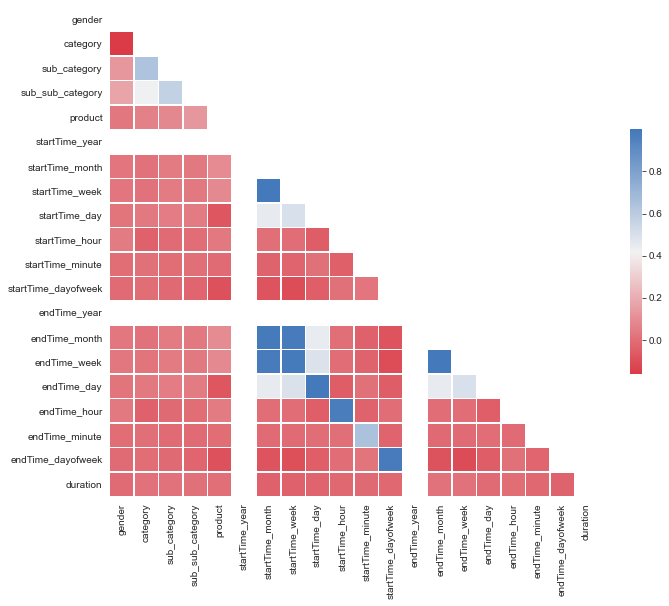

In [41]:
# Compute correlations
corr = train.corr()

# Exclude duplicate correlations by masking uper right values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set background color / chart style
sns.set_style(style = 'white')

# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Add diverging colormap
cmap = sns.diverging_palette(10, 250, as_cmap=True)

# Draw correlation plot
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)